### OpenCV DNN 패키지를 이용하여 MASK R-CNN 기반의 Object Detection/Instance Segmentation 수행
* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행. 

#### 입력 이미지로 사용될 이미지 다운로드/보기

In [1]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2021-10-08 03:24:01--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.06s   

2021-10-08 03:24:02 (5.67 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



image shape: (633, 806, 3)


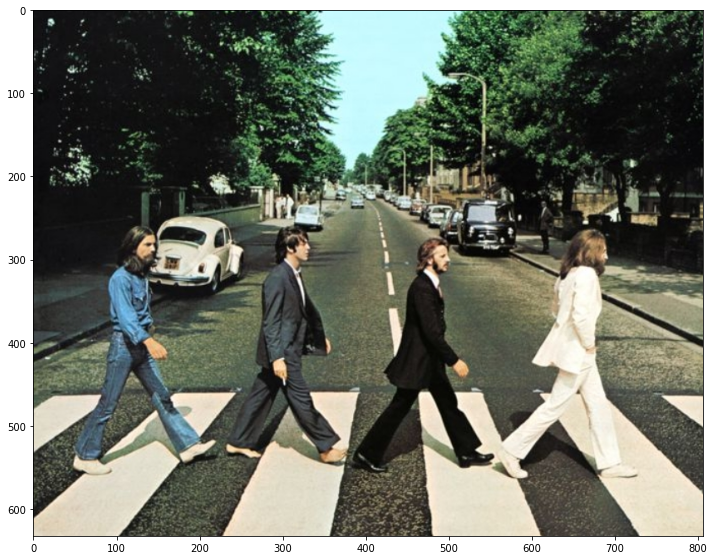

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt 에서 다운로드 
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 


In [3]:
!mkdir ./pretrained
!wget -O ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_mask_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt

--2021-10-08 03:26:23--  http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.188.128, 2404:6800:4008:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.188.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177817887 (170M) [application/x-tar]
Saving to: ‘./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’

./pretrained/mask_r 100%[===================>] 169.58M  53.8MB/s    in 3.2s    

2021-10-08 03:26:28 (53.8 MB/s) - ‘./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’ saved [177817887/177817887]

--2021-10-08 03:26:28--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com

In [4]:
!tar -xvf ./pretrained/mask*.tar.gz -C ./pretrained 

mask_rcnn_inception_v2_coco_2018_01_28/
mask_rcnn_inception_v2_coco_2018_01_28/model.ckpt.index
mask_rcnn_inception_v2_coco_2018_01_28/checkpoint
mask_rcnn_inception_v2_coco_2018_01_28/pipeline.config
mask_rcnn_inception_v2_coco_2018_01_28/model.ckpt.data-00000-of-00001
mask_rcnn_inception_v2_coco_2018_01_28/model.ckpt.meta
mask_rcnn_inception_v2_coco_2018_01_28/saved_model/
mask_rcnn_inception_v2_coco_2018_01_28/saved_model/saved_model.pb
mask_rcnn_inception_v2_coco_2018_01_28/saved_model/variables/
mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb


In [5]:
!pwd
!ls -lia ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28

/content
total 132684
19 drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 .
16 drwxr-xr-x 3 root   root     4096 Oct  8 03:27 ..
21 -rw-r--r-- 1 345018 5000       77 Feb  1  2018 checkpoint
28 -rw-r--r-- 1 345018 5000 67138064 Feb  1  2018 frozen_inference_graph.pb
23 -rw-r--r-- 1 345018 5000 63616508 Feb  1  2018 model.ckpt.data-00000-of-00001
20 -rw-r--r-- 1 345018 5000    16123 Feb  1  2018 model.ckpt.index
24 -rw-r--r-- 1 345018 5000  5069133 Feb  1  2018 model.ckpt.meta
22 -rw-r--r-- 1 345018 5000     3776 Feb  1  2018 pipeline.config
25 drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩 후 Inference 수행
* cv_net.forward() 수행 시 Bounding box Inference(bbox regression, bbox classification)과 mask inference 결과를 함께 출력하기 위해 layer명 detection_out_final, detection_masks 결과 가져옴

In [6]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                                        './pretrained/config_mask_graph.pbtxt')
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)
cv_net.setInput(blob)

boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

In [7]:
layer_names = cv_net.getLayerNames()
layer_names

['Preprocessor/mul',
 'Preprocessor/sub',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d/depthwise',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/Relu',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/MaxPool_2a_3x3/MaxPool',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Conv2D',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Relu',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/Conv2D',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/Relu',
 'FirstStageFeatureExtractor/InceptionV2/I

In [9]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}



#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

In [10]:
print('boxes shape:',boxes.shape, 'masks shape:',masks.shape)

boxes shape: (1, 1, 100, 7) masks shape: (100, 90, 15, 15)


In [11]:
masks[0].shape

(90, 15, 15)

In [12]:
import numpy as np

numClasses = masks.shape[1]
numDetections = boxes.shape[2]

draw_img = img_rgb.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

green_color = (0, 255, 0)
red_color = (0, 0, 255)

for i in range(1):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        caption = "{}:{:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, 2)
        cv2.putText(draw_img, caption, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

        classMask = mask[classId]
        print('Detec된 classMask shape:', classMask.shape)
        scaled_classMask = cv2.resize(classMask, (right-left + 1, bottom - top + 1))
        print('원본 오브젝트 비율로 scale out된 classMask shape:', scaled_classMask.shape)
        s_mask_b = (scaled_classMask > mask_threshold)
        print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              'scaled mask true shape:',s_mask_b[s_mask_b==True].shape, 
              'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)
        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)

Detec된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (284, 140)
scaled mask shape: (284, 140) scaled mask pixel count: 39760 scaled mask true shape: (19429,) scaled mask False shape: (20331,)
before_mask_roi: (284, 140, 3)


In [13]:
before_mask_roi

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0,   0, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 51,  47,  36],
        ...,
        [120, 129,  98],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 99, 104,  82],
        ...,
        [116, 117,  99],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [14]:
vis_mask = (s_mask_b * 255).astype('uint8')
instance = cv2.bitwise_and(before_mask_roi, before_mask_roi, mask=vis_mask)

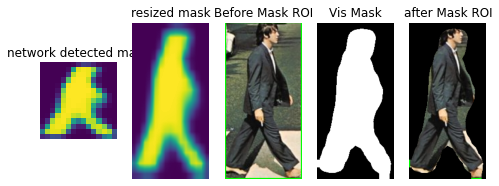

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(8, 8), ncols=5, nrows=1)

ax1.set_title('network detected mask')
ax1.axis('off')
ax1.imshow(classMask)

ax2.set_title('resized mask')
ax2.axis('off')
ax2.imshow(scaled_classMask)


ax3.set_title('Before Mask ROI')
ax3.axis('off')
ax3.imshow(before_mask_roi)

ax4.set_title('Vis Mask')
ax4.axis('off')
ax4.imshow(vis_mask, cmap='gray')

ax5.set_title('after Mask ROI')
ax5.axis('off')
ax5.imshow(instance)

[0, 255, 255]


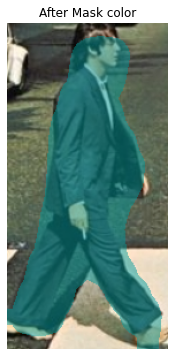

In [27]:
import numpy as np

draw_img = img_rgb.copy()

colorIndex = np.random.randint(0, len(colors)-1)
color = colors[colorIndex]
print(color)
after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.5 * after_mask_roi).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])

In [28]:
print('object image shape:', draw_img[top:bottom+1, left:right+1].shape)
print('boolena object mask:', s_mask_b, s_mask_b.shape)
print('object masking boolen index 결과 shape:', draw_img[top:bottom+1, left:right+1][s_mask_b].shape)

object image shape: (284, 140, 3)
boolena object mask: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]] (284, 140)
object masking boolen index 결과 shape: (19429, 3)


In [29]:
print('투명 color 적용 1:', [0.3*color[0], 0.3*color[1], 0.3*color[2]])
print('투명 color 적용 2:', 0.6 * after_mask_roi)

투명 color 적용 1: [0.0, 76.5, 76.5]
투명 color 적용 2: [[57.  51.  43.8]
 [40.2 34.2 28.2]
 [30.6 24.6 18.6]
 ...
 [44.4 43.2 35.4]
 [49.2 49.2 42. ]
 [58.2 58.2 52.2]]


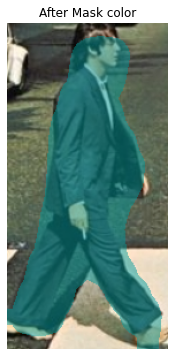

In [30]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])

#### Mask 정보를 이용하여 Detect된 Object에 contour 윤곽선 적용. 

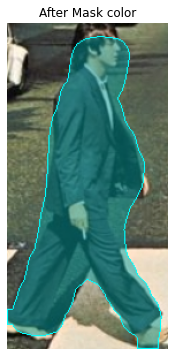

In [31]:
s_mask_i = s_mask_b.astype('uint8')
contours, hierarchy = cv2.findContours(s_mask_i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])

#### Detected된 Object들에 Mask 하여 시각화 

Detect된 classMask shape: (15, 15)
Original Object shape: (284, 140)
Detect된 classMask shape: (15, 15)
Original Object shape: (320, 151)
Detect된 classMask shape: (15, 15)
Original Object shape: (296, 178)
Detect된 classMask shape: (15, 15)
Original Object shape: (293, 163)
Detect된 classMask shape: (15, 15)
Original Object shape: (97, 111)
Detect된 classMask shape: (15, 15)
Original Object shape: (67, 76)
Detect된 classMask shape: (15, 15)
Original Object shape: (33, 36)
Detect된 classMask shape: (15, 15)
Original Object shape: (18, 25)
Detect된 classMask shape: (15, 15)
Original Object shape: (63, 23)
Detect된 classMask shape: (15, 15)
Original Object shape: (14, 14)
Detect된 classMask shape: (15, 15)
Original Object shape: (16, 17)
Detect된 classMask shape: (15, 15)
Original Object shape: (14, 18)


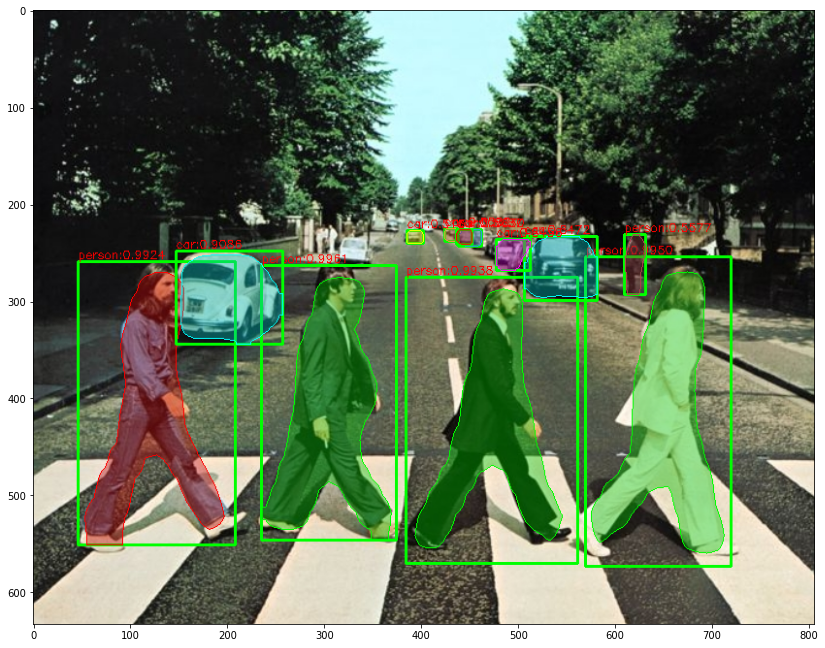

In [41]:
import numpy as np

numClasses = masks.shape[1]
numDetections = boxes.shape[2]

draw_img = img.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

green_color = (0, 255, 0)
red_color = (0, 0, 255)

for i in range(numDetections):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]

    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        caption = "{}:{:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, 2)
        cv2.putText(draw_img, caption, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

        classMask = mask[classId]
        print('Detect된 classMask shape:', classMask.shape)
        scaled_classMask = cv2.resize(classMask, (right - left +1, bottom - top + 1))
        print('Original Object shape:', scaled_classMask.shape)

        s_mask_b = (scaled_classMask > mask_threshold)
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
        draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)

        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(14, 14))
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.imshow(draw_img)
plt.show()

In [32]:
boxes.shape

(1, 1, 100, 7)

In [35]:
box = boxes[0,0,0]
box

array([0.        , 0.        , 0.99608445, 0.2921145 , 0.41625598,
       0.46419758, 0.86386406], dtype=float32)

In [42]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

In [65]:
def get_box_info(box, img_width, img_height):
    classId = int(box[1])
    score = box[2]
    left = int(img_width * box[3])
    top = int(img_height * box[4])
    right = int(img_width * box[5])
    bottom = int(img_height * box[6])

    return classId, score, left, top, right, bottom

def draw_box(image_array, box, img_width, img_height, is_print=True):
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    classId, score ,left, top, right, bottom = get_box_info(box, img_width, img_height)
    
    caption = "{}:{:.4f}".format(labels_to_names_seq[classId], score)
    cv2.rectangle(image_array, (left, top), (right, bottom), green_color, thickness=2 )
    cv2.putText(image_array, caption, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, thickness=1)

    return image_array


def draw_mask(image_array, box, mask, img_width, img_height, mask_threshold, is_print=True):
    classId, score ,left, top, right, bottom = get_box_info(box, img_width, img_height)
    classMask = mask[classId]
    scaled_Mask = cv2.resize(classMask, (right-left+1, bottom-top+1))
    s_mask_b = (scaled_Mask > mask_threshold)
    before_mask_roi = image_array[top:bottom+1, left:right+1]

    colorIndex = np.random.randint(0, len(colors)-1)
    color = colors[colorIndex]
    after_mask_roi = image_array[top:bottom+1, left:right+1][s_mask_b]
    image_array[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)

    s_mask_i = s_mask_b.astype(np.uint8)
    contours, hierarchy = cv2.findContours(s_mask_i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image_array[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

    return image_array

In [66]:
import time

def detec_image_mask_rcnn(cv_net, img_array, conf_threshold, mask_threshold, use_copy_img ,is_print=True):

    draw_img = None
    if use_copy_img:
        draw_img = img_array.copy()
    else:
        draw_img = img_array

    start_time = time.time()

    blob = cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False)
    cv_net.setInput(blob)
    boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

    inference_time = time.time() - start_time
    if is_print:
        print('Segmentation Inference time {0:}'.format(inference_time))

    numClasses = masks.shape[1]
    numDetections = masks.shape[2]

    img_height = img_array.shape[0]
    img_width = img_array.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]

        if score > conf_threshold:
            draw_box(img_array, box, img_width, img_height, is_print=True)
            draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=True)
    return img_array

image shape: (633, 806, 3)
Segmentation Inference time 7.069268226623535


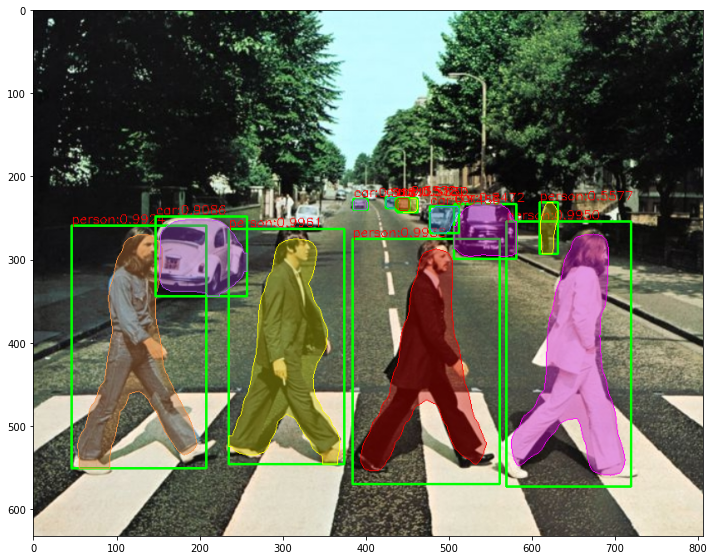

In [67]:
import os
# image 로드 
img = cv2.imread('./data/beatles01.jpg')
print('image shape:', img.shape)

cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_mask_graph.pbtxt')

img_detected = detec_image_mask_rcnn(cv_net, img, conf_threshold=0.5, mask_threshold=0.3, use_copy_img=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 다른 이미지 파일에 Segmentation 수행하기

In [68]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2021-10-08 04:56:19--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.02s   

2021-10-08 04:56:20 (4.71 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



image shape: (476, 735, 3)
Segmentation Inference time 6.475165128707886


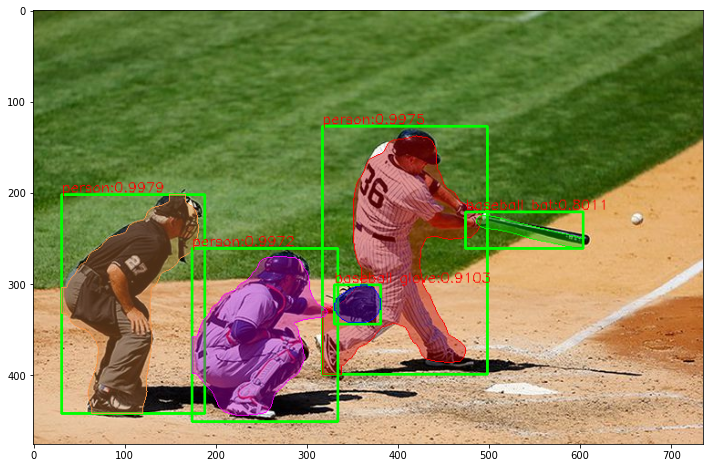

In [70]:
import os
# image 로드 
img = cv2.imread('./data/baseball01.jpg')
print('image shape:', img.shape)

cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_mask_graph.pbtxt')

# 야구공이 mask detect 되지 않아서 conf_threshold와 mask_threshold 를 낮춤. 
img_detected = detec_image_mask_rcnn(cv_net, img, conf_threshold=0.5, mask_threshold=0.3, use_copy_img=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 영상에 Segmentation 적용

In [71]:
!wget -O ./data/John_Wick_small.mp4 https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4

--2021-10-08 04:56:49--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1794863 (1.7M) [application/octet-stream]
Saving to: ‘./data/John_Wick_small.mp4’

./data/John_Wick_sm 100%[===================>]   1.71M  --.-KB/s    in 0.07s   

2021-10-08 04:56:51 (24.1 MB/s) - ‘./data/John_Wick_small.mp4’ saved [1794863/1794863]



In [73]:
def detect_video_mask_rcnn(cv_net, input_path, output_path, conf_threshold, mask_threshold,  is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, 24, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    frame_index=0
    while True:
        hasFrame, img_frame = cap.read()
        frame_index += 1
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        print("frame index:{0:}".format(frame_index), end=" ")
        returned_frame = detec_image_mask_rcnn(cv_net, img, conf_threshold=0.5, mask_threshold=0.3, use_copy_img=True, is_print=True)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [74]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_mask_graph.pbtxt')

detect_video_mask_rcnn(cv_net,'/content/data/John_Wick_small.mp4', '/content/data/John_Wick_mask_01.avi',
                      conf_threshold=0.5, mask_threshold=0.3, is_print=True)

총 Frame 갯수: 58
frame index:1 Segmentation Inference time 6.494438886642456
frame index:2 Segmentation Inference time 6.304233074188232
frame index:3 Segmentation Inference time 6.413158655166626
frame index:4 Segmentation Inference time 6.567422866821289
frame index:5 Segmentation Inference time 6.621366024017334
frame index:6 Segmentation Inference time 6.661532878875732
frame index:7 Segmentation Inference time 6.593291759490967
frame index:8 Segmentation Inference time 6.575143098831177
frame index:9 Segmentation Inference time 6.5075154304504395
frame index:10 Segmentation Inference time 6.45833420753479
frame index:11 Segmentation Inference time 6.490274429321289
frame index:12 Segmentation Inference time 6.4731764793396
frame index:13 Segmentation Inference time 6.494924783706665
frame index:14 Segmentation Inference time 6.452909231185913
frame index:15 Segmentation Inference time 6.4958412647247314
frame index:16 Segmentation Inference time 6.4090964794158936
frame index:17 Seg